In [1]:
pip install awkward yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install vector

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install uproot

Note: you may need to restart the kernel to use updated packages.


In [5]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward
plt.rcParams['figure.dpi'] = 100

import pandas as pd
import time

import vector
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import *
from sklearn import metrics
from yellowbrick.model_selection import validation_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier



pot = 1.3e22
r_mue = 3e-17

seed_value = 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)


import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

In [6]:
file_ce = uproot.open("Mu2eDriftAmbigCeMinusTracks.root")
file_dio = uproot.open("Mu2eDriftAmbigFlatDIOTracks.root")
trks_ce = file_ce['trks']
trks_dio = file_dio['trks']

In [7]:
p_ce = trks_ce.arrays(["px","py","pz"], aliases={"px": "kkmidmom/fCoordinates/fCoordinates.fX",
                                                    "py": "kkmidmom/fCoordinates/fCoordinates.fY",
                                                    "pz": "kkmidmom/fCoordinates/fCoordinates.fZ"})
p_dio = trks_dio.arrays(["px","py","pz"], aliases={"px": "kkmidmom/fCoordinates/fCoordinates.fX",
                                                   "py": "kkmidmom/fCoordinates/fCoordinates.fY",
                                                   "pz": "kkmidmom/fCoordinates/fCoordinates.fZ"})
p_mc_ce = trks_ce.arrays(["px","py","pz"], aliases={"px": "mcmidmom/fCoordinates/fCoordinates.fX",
                                                    "py": "mcmidmom/fCoordinates/fCoordinates.fY",
                                                    "pz": "mcmidmom/fCoordinates/fCoordinates.fZ"})
p_mc_dio = trks_dio.arrays(["px","py","pz"], aliases={"px": "mcmidmom/fCoordinates/fCoordinates.fX",
                                                      "py": "mcmidmom/fCoordinates/fCoordinates.fY",
                                                      "pz": "mcmidmom/fCoordinates/fCoordinates.fZ"})
ce_tinfo = trks_ce['tinfo'].arrays(library='pd')
ce_tinfo['kkmidt0'] = trks_ce['kkmidt0'].arrays(library='pd')
ce_tinfo['kkmidmomerr'] = trks_ce['kkmidmomerr'].arrays(library='pd')
ce_tinfo['weight'] = trks_ce['weight'].array()
ce_tinfo['kkmidmom'] = vector.awk(p_ce).mag
ce_tinfo['mcmidmom'] = vector.awk(p_mc_ce).mag
ce_tinfo[ce_tinfo['kkstatus'] <= 1]
ce_tinfo['class'] = 1

dio_tinfo = trks_dio['tinfo'].arrays(library='pd')
dio_tinfo['kkmidt0'] = trks_dio['kkmidt0'].arrays(library='pd')
dio_tinfo['kkmidmomerr'] = trks_dio['kkmidmomerr'].arrays(library='pd')
dio_tinfo['weight'] = trks_dio['weight'].array()
dio_tinfo['kkmidmom'] = vector.awk(p_dio).mag
dio_tinfo['mcmidmom'] = vector.awk(p_mc_dio).mag
dio_tinfo['class'] = 0
dio_tinfo[dio_tinfo['kkstatus'] <= 1]
dio_tinfo = dio_tinfo
full = pd.concat([ce_tinfo, dio_tinfo],ignore_index=True)

In [8]:
good_quality = (full['kkstatus'] <= 1) & (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1)
bad_quality = (full['kkstatus'] <= 1) & (np.abs(full['kkmidmom']-full['mcmidmom']) > 1.5)

In [9]:
test_size = 0.4
seed = 7
train_sample = full[good_quality | bad_quality]
train_sample['quality'] = (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1).astype(int)
X, Y = train_sample.loc[:, train_sample.columns!='quality'], train_sample['quality']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

/tmp/ipykernel_3311/2615987079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sample['quality'] = (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1).astype(int)


Random Forest Tuning:

increasing N_estimators diminishing returns after 1000. Entropy gives best results for criterion

In [10]:

clf = RandomForestClassifier(n_estimators=1500,max_depth=10,criterion= 'entropy', max_features='log2')
X_train_df = X_train.loc[:, ~X_train.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])]
clf.fit(X_train_df, y_train)
X_test['score'] = clf.predict_proba(X_test.loc[:, ~X_test.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])])[:,1]

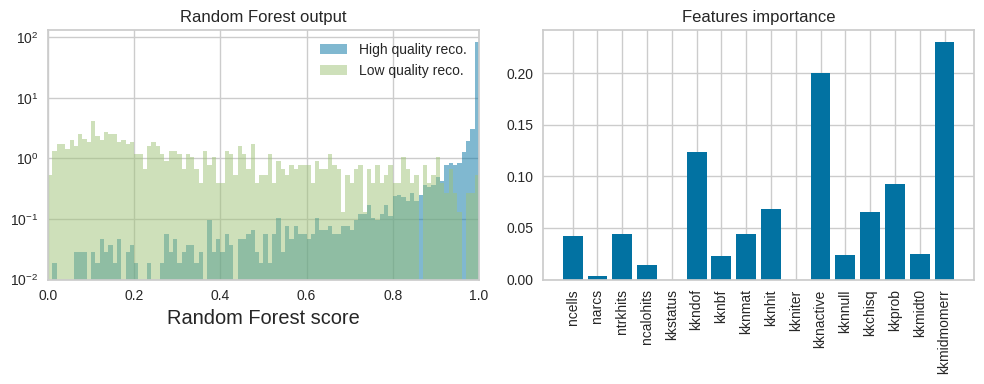

In [12]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
ax[0].hist(X_test['score'][y_test==1], range=(0,1), density=True, bins=100, alpha=0.5, label='High quality reco.')
ax[0].hist(X_test['score'][y_test==0], range=(0,1), density=True, bins=100, alpha=0.5, label='Low quality reco.')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlim(0,1)
ax[0].set_ylim(bottom=0.01)
ax[0].set_xlabel("Random Forest score", fontsize='large')
ax[1].bar(X_train_df.keys(),clf.feature_importances_)
for label in ax[1].get_xticklabels():
    label.set_rotation(90)
ax[1].set_title("Features importance")
_=ax[0].set_title("Random Forest output")

#rnadom forest #plot next to each other

In [13]:
#Tuning parameters

#model = XGBClassifier(max_depth=6, n_estimators=500,learning_rate = 0.01, subsample=.5, colsample_bytree=.5, colsample_bylevel=.8999999999)
#X_train_df = X_train.loc[:, ~X_train.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])]
#model.fit(X_train_df, y_train, eval_metric='logloss')
#params = {'max_depth': [3, 5, 6, 10, 15, 20],
           #'learning_rate': [0.01, 0.1, 0.2, 0.3],
           #'subsample': np.arange(0.5, 1.0, 0.1),
          # 'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          # 'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          # 'n_estimators': [100, 500, 1000]}
#boost = RandomizedSearchCV(estimator=model,
                         #param_distributions=params,
                         #scoring='roc_auc',
                         #n_iter=20,
                         #verbose=1)
    
#boost.fit(X_train_df, y_train, eval_metric='logloss')                      
#print("Best parameters:", boost.best_params_)

#Best parameters: {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}


In [17]:
X2, Y2 = train_sample.loc[:, train_sample.columns!='quality'], train_sample['quality']
x_train, x_test, y_train2, y_test2 = train_test_split(X2, Y2, test_size=test_size, random_state=seed)

model = XGBClassifier(max_depth=6, n_estimators=500,learning_rate = 0.01, subsample=.5, colsample_bytree=.5, colsample_bylevel=0.899999)
x_train_df = x_train.loc[:, ~x_train.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])]
model.fit(x_train_df, y_train, eval_metric='logloss')
x_test['score'] = model.predict_proba(x_test.loc[:, ~x_test.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])])[:,1]

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [19]:
X3, Y3 = train_sample.loc[:, train_sample.columns!='quality'], train_sample['quality']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=test_size, random_state=seed)
X_train_df3 = X_train3.loc[:, ~X_train3.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])]
not_training = pd.concat((X_test, full[(~good_quality) & (~bad_quality)]))

mlp = MLPClassifier(hidden_layer_sizes=(200,), max_iter=100,activation = 'logistic',solver='adam',random_state=1, learning_rate='constant')
X_train_df3 = X_train3.loc[:, ~X_train3.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])]
mlp.fit(X_train_df3, y_train3)
X_test3['score'] = mlp.predict_proba(X_test3.loc[:, ~X_test3.columns.isin(['kkmidmom', 'mcmidmom', 'weight', 'class'])])[:,1]

Best parameters found: for Mlpclassifier

  {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'solver': 'adam'}


### Tuning

    -MlP Classifier: logistic (sigmoid) alpha:.0001
    -Random Forest: entropy criterion, max depth: 10, N_iterations: 1500
    -XGBoost: max depth= 6 n_estimators = 500 subsample=.5, colsample_bytree=.5, colsample_bylevel=0.899999
    -All found with grid search
    -created validation curve for finding max depth
    
 ### Untuned Results
     XGB: .983
     Random Forest: .984
     Neural Network:.94
     Neural Network tuning yielded the biggest improvement, but was still outperformed by BDT and Random Forest
 
 ### Todo:
     -Still need to test Regression Classification/tune
     - Neural Network, tried testing different hidden layer sizes but would cause Kernal to crash
     - Tried tuning Hyperparameters more with XGBoost with RandomizedSearchCV but used too much memory
     - Tuning limited by memory. Jupyter Notebook was very fickle when tuning and would crash if too many parameters were     
     tested
     
     

0.9854795048434555
0.98533056002751


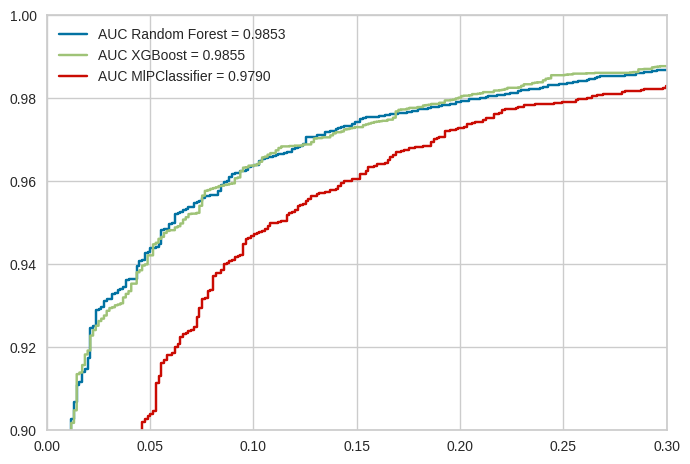

In [23]:

fpr, tpr, threshold = metrics.roc_curve(y_test, X_test['score'], pos_label=1)
fpr_xgb, tpr_xgb, threshold = metrics.roc_curve(y_test2, x_test['score'], pos_label=1)
fpr_mlp, tpr_mlp, threshhold = metrics.roc_curve(y_test3, X_test3['score'], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc_xgb=metrics.auc(fpr_xgb,tpr_xgb)
roc_auc_mlp=metrics.auc(fpr_mlp,tpr_mlp)

plt.plot(fpr,tpr,label = 'AUC Random Forest = %0.4f' % roc_auc)
plt.plot(fpr_xgb,tpr_xgb,label = 'AUC XGBoost = %0.4f' % roc_auc_xgb)
plt.plot(fpr_mlp,tpr_mlp,label = "AUC MlPClassifier = %.4f" %roc_auc_mlp)
plt.xlim(0,.3)
plt.ylim(.9,1)
_=plt.legend()

print(roc_auc_xgb)
print(roc_auc)